#House Price - linear regression

1. Idea je vybrat takové features, které se dají z inzerce, katastru, mapy a poptání sousedů zjistit 
   bez prohlídky 
2. Když exploratory analýzy vybere "best features", budeme je hodnotit s ohledem na bod 1 a ty, které nebudou
   vyhovovat budeme eliminovat a vybírat další vhodné
3. Horní limit pro predikci hodnoty nemovitosti je 20 features, raději méně
4. Domácí úkol: Dataset s House Price, který obsahuje ZIP propojit se socioekonomickými daty a teprve z něj dělat
   predikce

##Load data from files downloaded from Kaggle

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, root_mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
import datetime

In [3]:
#%pip install shap

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#file_train='/content/drive/MyDrive/Colab Notebooks/Kagle_Competition/House_Price/train.csv'
#file_test='/content/drive/MyDrive/Colab Notebooks/Kagle_Competition/House_Price/test.csv'
#https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
file_train='train.csv'
file_test='test.csv'


In [6]:
train_df = pd.read_csv(file_train) 
test_df = pd.read_csv(file_test) 
df_sub = pd.read_csv('sample_submission.csv')

In [7]:
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [8]:
#Statistics, Age and LotFrontage is not allways filled - see row count
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
#Data types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [10]:
# It's allways necessary to check train data too
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [11]:
# find categorical variables
categorical = [col for col in train_df.columns if train_df[col].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))
train_df[categorical].head()

There are 43 categorical variables


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [12]:
# find numerical variables
numerical = [col for col in train_df.columns if train_df[col].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))
train_df[numerical].head()

There are 38 numerical variables


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


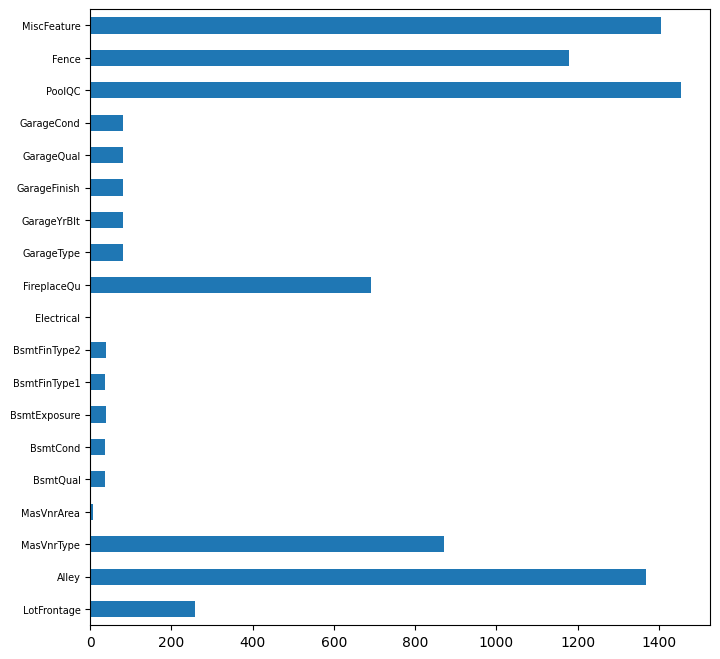

In [13]:
#null values
import matplotlib.pyplot as plt
null_counts = train_df.isnull().sum()
null_counts = null_counts[null_counts > 0]
plt.figure(figsize=(8, 8))
null_counts.plot(kind='barh')
plt.yticks(fontsize=7)
plt.show()

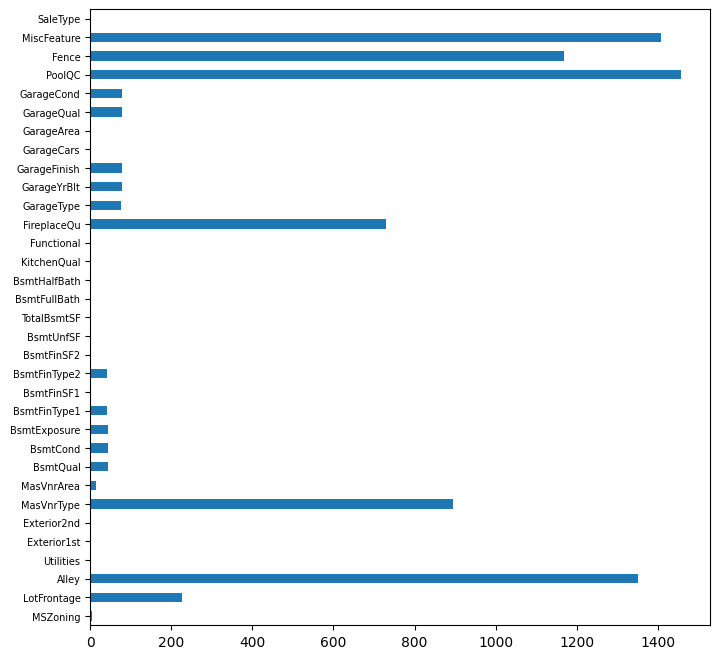

In [14]:
null_counts = test_df.isnull().sum()
null_counts = null_counts[null_counts > 0]
plt.figure(figsize=(8, 8))
null_counts.plot(kind='barh')
plt.yticks(fontsize=7)
plt.show()

In [15]:
train_df["Neighborhood"].unique() 

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [16]:
train_df['MSZoning'].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [17]:
train_df["HouseStyle"].unique()

array(['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf',
       '2.5Fin'], dtype=object)

In [18]:
train_df["Street"].unique()

array(['Pave', 'Grvl'], dtype=object)

In [19]:
train_df["Alley"].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [20]:
train_df['MSSubClass'].value_counts()

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64

In [21]:
train_df.groupby("LotShape")["SalePrice"].mean()

LotShape
IR1    206101.665289
IR2    239833.365854
IR3    216036.500000
Reg    164754.818378
Name: SalePrice, dtype: float64

In [22]:
train_df.nlargest(10, "LotArea")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000
457,458,20,RL,NaN,53227,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,256000
384,385,60,RL,NaN,53107,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,240000


In [23]:
train_df.groupby("BldgType")["SalePrice"].mean()

BldgType
1Fam      185763.807377
2fmCon    128432.258065
Duplex    133541.076923
Twnhs     135911.627907
TwnhsE    181959.342105
Name: SalePrice, dtype: float64

In [24]:
train_df.groupby("Foundation")["SalePrice"].mean()

Foundation
BrkTil    132291.075342
CBlock    149805.714511
PConc     225230.442040
Slab      107365.625000
Stone     165959.166667
Wood      185666.666667
Name: SalePrice, dtype: float64

In [25]:
train_df.groupby("CentralAir")["SalePrice"].mean()

CentralAir
N    105264.073684
Y    186186.709890
Name: SalePrice, dtype: float64

In [26]:
test_df["KitchenQual"].value_counts()

KitchenQual
TA    757
Gd    565
Ex    105
Fa     31
Name: count, dtype: int64

# Preprocessing

In [27]:
#it is necessary join train and test data to contain same columns after usage of get_dummies function
df_complet = pd.concat([train_df, test_df])
#zresetování indexu
df_complet = df_complet.reset_index(drop=True).reset_index()
print(f'train_df shape   : {train_df.shape}')
print(f'test_df shape    : {test_df.shape}')
print(f'df_complet shape : {df_complet.shape}')

train_df shape   : (1460, 81)
test_df shape    : (1459, 80)
df_complet shape : (2919, 82)


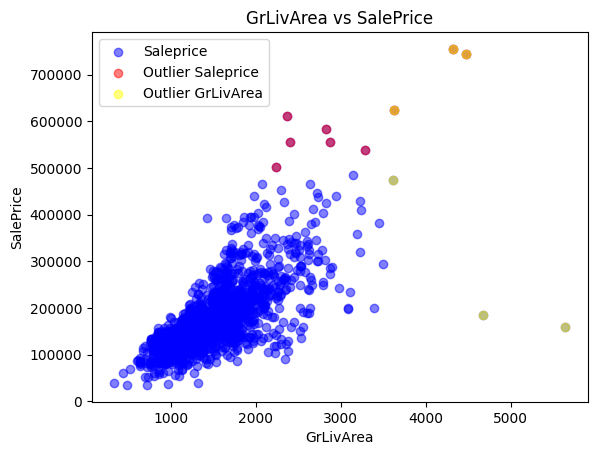

In [28]:
#Plot GrLivArea vs SalePrice https://www.kaggle.com/code/felipefiorini/house-prices-xgboost-outlier-detect
df_oSalePrice = df_complet.query('SalePrice >= 500000')
df_oGrLivAreA = df_complet.query('GrLivArea >= 3500')
plt.scatter(df_complet['GrLivArea'], df_complet['SalePrice'], color='blue', alpha=0.5,label='Saleprice')
plt.scatter(df_oSalePrice['GrLivArea'],   df_oSalePrice['SalePrice'],   color='red',  alpha=0.5, label='Outlier Saleprice')
plt.scatter(df_oGrLivAreA['GrLivArea'],   df_oGrLivAreA['SalePrice'],   color='yellow',  alpha=0.5, label='Outlier GrLivArea')
plt.legend(loc="upper left")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [29]:
pd.options.mode.copy_on_write = True #warning removal
y = train_df[['Id', 'SalePrice']]
y['Id'] = y['Id'] -1 
y.rename(columns = {'Id':'index'}, inplace = True)
new_submission = test_df[["Id"]] #Id preserved
new_submission.head()

,Id
0,1461
1,1462
2,1463
3,1464
4,1465


In [30]:
# Optional outlier handling
#Outliers
outliers_input = pd.DataFrame()

def outlier_shrink(df):
    df = df.select_dtypes(include='number')
    df = df.fillna(0)
    startcnt = df.shape[0]
    df = df.query('SalePrice < 500000')
    aftercnt = df.shape[0]
    print(f'Row start: {startcnt} end: {aftercnt} decrease by SalePrice: {startcnt - aftercnt}')
    startcnt = aftercnt
    df = df.query('LotFrontage < 200')
    aftercnt = df.shape[0]
    print(f'Row start: {startcnt} end: {aftercnt} decrease by LotFrontage: {startcnt - aftercnt}')
    startcnt = aftercnt
    df = df.query('LotArea < 60000')
    aftercnt = df.shape[0]
    print(f'Row start: {startcnt} end: {aftercnt} decrease by LotArea: {startcnt - aftercnt}')
    startcnt = aftercnt
    df = df.query('MasVnrArea < 1250')
    aftercnt = df.shape[0]
    print(f'Row start: {startcnt} end: {aftercnt} decrease by MasVnrArea: {startcnt - aftercnt}')
    startcnt = aftercnt
    df = df.query('TotalBsmtSF < 2500')
    aftercnt = df.shape[0]
    print(f'Row start: {startcnt} end: {aftercnt} decrease by TotalBsmtSF: {startcnt - aftercnt}')
    startcnt = aftercnt
    df = df.query('YearBuilt > 1880')
    aftercnt = df.shape[0]
    print(f'Row start: {startcnt} end: {aftercnt} decrease by YearBuilt: {startcnt - aftercnt}')
    startcnt = aftercnt
    df = df.query('LowQualFinSF < 300')
    aftercnt = df.shape[0]
    print(f'Row start: {startcnt} end: {aftercnt} decrease by LowQualFinSF: {startcnt - aftercnt}')
    startcnt = aftercnt
    df = df.query('GrLivArea < 3000')
    aftercnt = df.shape[0]
    print(f'Row start: {startcnt} end: {aftercnt} decrease by GrLivArea: {startcnt - aftercnt}')
    startcnt = aftercnt
    df = df.query('GarageArea < 1200')
    aftercnt = df.shape[0]
    print(f'Row start: {startcnt} end: {aftercnt} decrease by GarageArea: {startcnt - aftercnt}')
    startcnt = aftercnt
    df = df.query('PoolArea < 500')
    aftercnt = df.shape[0]
    print(f'Row start: {startcnt} end: {aftercnt} decrease by PoolArea: {startcnt - aftercnt}')
    return (df)

outliers_input = outlier_shrink(df_complet)

print("outliers_input shape: ", outliers_input.shape)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

outliers = pd.DataFrame()

def detect_outliers(df):    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))    
    return df[outlier_mask]

# Apply the function to get outliers
numerical = train_df.select_dtypes(include='number').columns
outliers = pd.DataFrame()

for column in numerical:
    outliers[column] = detect_outliers(df_complet[column])
    
    fig, ax = plt.subplots(figsize=(2, 3))
    outliers_input[[column]].boxplot(ax=ax)  # Only plot the current column
    plt.xticks(rotation=45)
    plt.ylabel('Values')
    plt.title(f'Boxplot for {column}')
    #plt.show()
    plt.close()
# Display the outliers
#print(outliers)

outliers_input = outliers_input.iloc[:,[0]] #ponecháme jen index pro budoucí merge
outliers_input.rename(columns = {'Id':'index'}, inplace = True) #a přejmenujeme na index


Row start: 2919 end: 2910 decrease by SalePrice: 9
Row start: 2910 end: 2907 decrease by LotFrontage: 3
Row start: 2907 end: 2902 decrease by LotArea: 5
Row start: 2902 end: 2900 decrease by MasVnrArea: 2
Row start: 2900 end: 2889 decrease by TotalBsmtSF: 11
Row start: 2889 end: 2881 decrease by YearBuilt: 8
Row start: 2881 end: 2857 decrease by LowQualFinSF: 24
Row start: 2857 end: 2845 decrease by GrLivArea: 12
Row start: 2845 end: 2837 decrease by GarageArea: 8
Row start: 2837 end: 2832 decrease by PoolArea: 5
outliers_input shape:  (2832, 39)


In [31]:
#one function for train and test
def preproces_data(x):
  x_output = x
  pd.set_option('future.no_silent_downcasting', True)
  for var in ['Id', 'SalePrice']:
    if var in x_output.columns:
      x_output.drop(var, inplace=True, axis =1) #remove Id and Saleprice if exists
  
  x_output['MasVnrArea'] = x_output['MasVnrArea'].fillna(0)
  x_output['BsmtFinSF1'] = x_output['BsmtFinSF1'].fillna(0)
  x_output['BsmtFinSF2'] = x_output['BsmtFinSF2'].fillna(0)
  x_output['BsmtUnfSF'] = x_output['BsmtUnfSF'].fillna(0)
  x_output['TotalBsmtSF'] = x_output['TotalBsmtSF'].fillna(0).astype(float)
  x_output['MSZoning'] = x_output['MSZoning'].fillna('RL')
  x_output['ExterQual'] = x_output['ExterQual'].fillna('TA')
  x_output['HouseStyle'] = x_output['HouseStyle'].fillna('1Story')
  x_output['BsmtCond'] = x_output['BsmtCond'].fillna('Po')
  x_output['KitchenQual'] = x_output['KitchenQual'].fillna('TA')
  x_output['GarageQual'] = x_output['GarageQual'].fillna('NA')
  x_output['Fence'] = x_output['Fence'].fillna('NA')
  x_output['FireplaceQu'] = x_output['FireplaceQu'].fillna('NAN')
  x_output['LotFrontage'] = x_output['LotFrontage'].fillna(0).astype(float) #x_output['LotFrontage'].mean()
  x_output['OpenPorchSF'] = x_output['OpenPorchSF'].fillna(0).astype(float)
  x_output['EnclosedPorch'] = x_output['EnclosedPorch'].fillna(0).astype(float)
  x_output['3SsnPorch'] = x_output['3SsnPorch'].fillna(0).astype(float)
  x_output['ScreenPorch'] = x_output['ScreenPorch'].fillna(0).astype(float)
  x_output['GarageYrBlt'] = x_output['GarageYrBlt'].fillna(0)
  x_output['LotArea'] = x_output['LotArea'].fillna(0)
  x_output['GarageCars'] = x_output['GarageCars'].fillna(0)
  x_output['GarageArea'] = x_output['GarageArea'].fillna(0)
  x_output['BsmtHalfBath'] = x_output['BsmtHalfBath'].fillna(0)
  x_output['RemodAdd'] = 2010 - x_output['YearRemodAdd']
  x_output = x_output.drop(columns=['YearRemodAdd'])
  x_output['Neighborhood'] = x_output['Neighborhood'].str.strip()
  x_output['Crime'] = x_output['Neighborhood'].apply(lambda x: 2 if x in ('NoRidge', 'NridgHt', 'OldTown', 'BrkSide', 'IDOTRR') 
                                                     else 1 if x in ('Blmngtn', 'Blueste', 'CollgCr', 'Edwards', 'MeadowV', 'NPkVill', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst') 
                                                     else 0)
  X_input = x_output
  X_input = x_output.fillna(0)

  x_output = pd.get_dummies(X_input, drop_first = True) #Transform "object" features to feature + value 

  X_input = x_output
  x_output = X_input.fillna(0)
  
  x_output = x_output.replace({True: 1, False: 0}).astype(int) #replace True False to 1, 0 for p.value calculation

  return(x_output)

In [32]:
df_complet["Neighborhood"].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [33]:
#preprocessing function call
X_complet = preproces_data(df_complet)
X_complet = X_complet.drop(columns=['Neighborhood_StoneBr'])
print(f"df_complet shape: {X_complet.shape}") #+-260 columns

df_complet shape: (2919, 265)


In [34]:
X_complet.columns

Index(['index', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=265)

In [35]:
#data split back to dataframes train and test
train_df = pd.DataFrame()
test_df = pd.DataFrame()
train_df = X_complet.loc[0:1459,:] # insert 0 .. 1459 rows and all cols
test_df = X_complet.loc[1460:,:] # insert 1460 .. 2919 rows and all cols
print(f"train_df shape           : {train_df.shape}")
print(f"test_df shape            : {test_df.shape}")
#cut outliers
X = pd.merge(outliers_input, train_df) #outliers removed based on index
y = pd.merge(outliers_input, y)        #outliers removed based on index
X.reset_index(drop=True).reset_index() #because of missing rows reset index
y.reset_index(drop=True).reset_index() #because of missing rows reset index
y = y.drop(columns=['index'])
print(f"X without outlier        : {X.shape}")
print(f"y                        : {y.shape}")

#nulls
print(f"X NaN                    : {X.isnull().sum().sum()}")
#X.head()

train_df shape           : (1460, 265)
test_df shape            : (1459, 265)
X without outlier        : (1403, 265)
y                        : (1403, 1)
X NaN                    : 0


In [36]:
#columns by p-value
X = sm.add_constant(X)
X.index = y.index
model = sm.OLS(y, X).fit()
p_values = model.pvalues
p_values_df = pd.DataFrame(p_values, columns=['p_value'])
p_values_df = p_values_df.sort_values(by='p_value', ascending=True) #lowest p-value is more significant
print(p_values_df)
#we can use cycle and ad features with lowest p-value and compare mean error for improvement
#other method is to extract features and observe impact to mean error

                            p_value
Neighborhood_Mitchel   2.630509e-16
OverallQual            6.583165e-15
Neighborhood_NAmes     1.133698e-14
Neighborhood_Gilbert   3.235429e-14
Neighborhood_NWAmes    3.928570e-14
OverallCond            2.387144e-12
LotArea                4.584516e-12
Neighborhood_Timber    1.396080e-11
BsmtFinSF1             4.594619e-11
KitchenQual_Gd         1.755233e-10
TotalBsmtSF            3.392234e-09
Neighborhood_ClearCr   6.337451e-09
KitchenQual_TA         3.141121e-08
YearBuilt              4.089895e-07
PoolQC_Ex              3.132739e-06
Crime                  3.188103e-06
Neighborhood_NridgHt   1.983008e-05
LandSlope_Sev          2.518295e-05
ExterQual_TA           2.866573e-05
Condition1_Norm        6.454206e-05
ExterQual_Gd           6.713673e-05
Neighborhood_NoRidge   7.198946e-05
WoodDeckSF             1.162473e-04
MSZoning_RL            2.833463e-04
MSZoning_FV            2.925578e-04
MSZoning_RM            1.673283e-03
BsmtCond_Po            1.715

In [37]:
#there is 266 features, so we should define some border for next processing
p_values_df_sel = p_values_df.query('p_value <= 1').sort_values('p_value') #Select features by p_value, 1 for all
print("Selected: ",p_values_df_sel.shape)
rows_to_retain = p_values_df.index.difference(p_values_df_sel.index)
p_values_df_notsel = p_values_df.loc[list(rows_to_retain)] #Not selected features
print("Not selected: ",p_values_df_notsel.shape)
#display(p_values_df)

Selected:  (265, 1)
Not selected:  (1, 1)


In [38]:
p_values_df_sel.head(10)

,p_value
Neighborhood_Mitchel,2.630509e-16
OverallQual,6.583165e-15
Neighborhood_NAmes,1.133698e-14
Neighborhood_Gilbert,3.235429e-14
Neighborhood_NWAmes,3.928570e-14
OverallCond,2.387144e-12
LotArea,4.584516e-12
Neighborhood_Timber,1.396080e-11
BsmtFinSF1,4.594619e-11
KitchenQual_Gd,1.755233e-10


In [39]:
index_values = p_values_df_sel.index.tolist()
p_values_df_sel_col = pd.DataFrame()
p_values_df_sel_col.index = index_values
print(len(p_values_df_sel_col))
selected_features = list(p_values_df_sel_col.index)
print("Selected subset of features for next processing: \n", selected_features)


265
Selected subset of features for next processing: 
 ['Neighborhood_Mitchel', 'OverallQual', 'Neighborhood_NAmes', 'Neighborhood_Gilbert', 'Neighborhood_NWAmes', 'OverallCond', 'LotArea', 'Neighborhood_Timber', 'BsmtFinSF1', 'KitchenQual_Gd', 'TotalBsmtSF', 'Neighborhood_ClearCr', 'KitchenQual_TA', 'YearBuilt', 'PoolQC_Ex', 'Crime', 'Neighborhood_NridgHt', 'LandSlope_Sev', 'ExterQual_TA', 'Condition1_Norm', 'ExterQual_Gd', 'Neighborhood_NoRidge', 'WoodDeckSF', 'MSZoning_RL', 'MSZoning_FV', 'MSZoning_RM', 'BsmtCond_Po', 'KitchenQual_Fa', 'SaleCondition_Normal', 'MSZoning_RH', 'Neighborhood_BrDale', 'GarageArea', 'Neighborhood_Veenker', '2ndFlrSF', 'ScreenPorch', 'LandContour_Low', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'RoofStyle_Shed', 'RemodAdd', 'LotConfig_FR2', 'BedroomAbvGr', 'Condition1_PosN', 'Condition1_RRAe', 'BldgType_Twnhs', 'KitchenAbvGr', 'OpenPorchSF', 'Neighborhood_Edwards', 'Foundation_Wood', 'BsmtQual_Ex', 'Neighborhood_IDOTRR', 'Fence_MnPrv', 'ExterQual_Fa',

In [40]:
answer = input("Do you want to process feature selection again = 'Y', otherwise features from previous run will be loaded 'N'")
print(answer)

In [41]:
# Function to evaluate model and get mean squared error
if answer == 'Y':

    columns = []
    def evaluate_model(features):
        X_with_const = sm.add_constant(features)
        model = sm.OLS(y, X_with_const).fit()
        predictions = model.predict(X_with_const)
        mse = mean_squared_error(y, predictions)
        return mse, model.pvalues

    # Initial empty set of features
    selected_features = []
    remaining_features = list(p_values_df_sel_col.index)

    # Track the improvement in model error
    best_mse = float('inf')
    sel_feature_cnt  = 0
    iteration_cnt = 0

    while remaining_features and len(p_values_df_sel_col) > iteration_cnt:        
        p_values_dict = {}
        mse_dict = {}
        iteration_cnt += 1
        # Evaluate each feature not yet selected
        for feature in remaining_features:
            features_to_evaluate = selected_features + [feature]
            mse, p_values = evaluate_model(X[features_to_evaluate])
            p_values_dict[feature] = p_values
            mse_dict[feature] = mse

        # Select the feature that gives the best improvement in MSE
        best_feature = min(mse_dict, key=mse_dict.get)
        best_feature_mse = mse_dict[best_feature]

        # Check if the new model is better
        if best_feature_mse < best_mse:
            best_mse = best_feature_mse
            selected_features.append(best_feature)
            sel_feature_cnt += 1
            remaining_features.remove(best_feature)
            print(f"best_feature append: {best_feature}  ME: {np.sqrt(best_feature_mse)} Selected feature count: {sel_feature_cnt}")        
        else:
            # If no improvement, break the loop
            #break
            pass

    # Final model with selected features
    final_mse, final_p_values = evaluate_model(X[selected_features])
    final_p_values_df = pd.DataFrame(final_p_values, columns=['p-value'])

    # Open a file in write binary mode
    with open('my_final_project_p_values_df.pkl', 'wb') as f:
        final_p_values_df = final_p_values_df.drop(index='const')
        pickle.dump(final_p_values_df, f)

    # Display the final p-values and selected features
    print(f"Selected features: {selected_features}")
    print(f"Final model ME: {np.sqrt(best_mse)}")

else:
  with open('my_final_project_p_values_df.pkl', 'rb') as f:
    final_p_values_df = pd.DataFrame(pickle.load(f))    

print(final_p_values_df.head(10))


                   p-value
OverallQual   6.583165e-15
GrLivArea     6.429252e-01
BsmtFinSF1    1.246622e-01
BsmtQual_Ex   5.963361e-02
YearBuilt     4.089895e-07
MSSubClass    6.256289e-01
SaleType_New  1.612350e-01
OverallCond   2.387144e-12
LotArea       4.584516e-12
ExterQual_TA  2.866573e-05


In [42]:
selected_features = final_p_values_df.index.tolist()

In [43]:
#selected subset of columns, when previous code run for all 266 colls 17 minutes locally ME is 20196
#but no signifficant improvement after 236 feature, but more features means propensity to overfitting
col_sel = selected_features[:236]
col_sel_limited = selected_features[:100]
print(X.shape)
print(test_df.shape)
print(len(col_sel_limited))

(1403, 266)
(1459, 265)
100


In [44]:
X[col_sel_limited].head(5)

,OverallQual,GrLivArea,BsmtFinSF1,BsmtQual_Ex,YearBuilt,MSSubClass,SaleType_New,OverallCond,LotArea,ExterQual_TA,Neighborhood_NridgHt,BsmtExposure_Gd,Neighborhood_Crawfor,GarageArea,Neighborhood_NoRidge,TotalBsmtSF,SaleCondition_Normal,ExterQual_Gd,Functional_Typ,BedroomAbvGr,Condition1_Norm,Exterior1st_BrkFace,KitchenAbvGr,Neighborhood_BrkSide,ExterQual_Fa,GarageQual_NA,WoodDeckSF,Neighborhood_Somerst,BsmtFullBath,Neighborhood_Mitchel,MSZoning_RL,Functional_Sev,RemodAdd,BsmtCond_Po,Street_Pave,GarageType_BuiltIn,LandSlope_Sev,LotConfig_CulDSac,Foundation_PConc,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Fa,Fireplaces,2ndFlrSF,BsmtFinType1_GLQ,RoofMatl_Tar&Grv,Condition1_RRAe,ScreenPorch,RoofMatl_Membran,LandContour_HLS,SaleType_Con,Neighborhood_Edwards,BldgType_2fmCon,Condition2_PosA,GarageCars,BsmtExposure_Av,Foundation_Wood,LotConfig_FR2,Exterior2nd_CmentBd,Neighborhood_MeadowV,Exterior2nd_VinylSd,Exterior1st_MetalSd,BsmtUnfSF,Neighborhood_NAmes,MasVnrArea,Neighborhood_NWAmes,Condition1_PosN,Neighborhood_CollgCr,Neighborhood_Gilbert,Neighborhood_Timber,Crime,Neighborhood_ClearCr,Neighborhood_Sawyer,BldgType_Twnhs,BldgType_TwnhsE,Neighborhood_SawyerW,SaleType_CWD,Neighborhood_Veenker,Neighborhood_BrDale,Neighborhood_SWISU,ExterCond_Gd,LandContour_Low,HeatingQC_TA,GarageType_2Types,OpenPorchSF,RoofMatl_CompShg,Functional_Maj2,3SsnPorch,Exterior1st_Stucco,Exterior2nd_Wd Sdng,GarageFinish_RFn,Functional_Mod,Exterior1st_CemntBd,Exterior1st_Wd Sdng,LandSlope_Mod,BsmtQual_Gd,Utilities_NoSeWa,MasVnrType_BrkCmn,SaleCondition_AdjLand,1stFlrSF
0,7,1710,706,0,2003,60,0,5,8450,0,0,0,0,548,0,856,1,1,1,3,1,0,1,0,0,0,0,0,1,0,1,0,7,0,1,0,0,0,1,1,0,0,0,854,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,150,0,196,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,61,1,0,0,0,0,1,0,0,0,0,1,0,0,0,856
1,6,1262,978,0,1976,20,0,8,9600,1,0,1,0,460,0,1262,1,0,1,3,0,0,1,0,0,0,298,0,0,0,1,0,34,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1262
2,7,1786,486,0,2001,60,0,5,11250,0,0,0,0,608,0,920,1,1,1,3,1,0,1,0,0,0,0,0,1,0,1,0,8,0,1,0,0,0,1,1,0,0,1,866,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,434,0,162,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,42,1,0,0,0,0,1,0,0,0,0,1,0,0,0,920
3,7,1717,216,0,1915,70,0,5,9550,1,0,0,1,642,0,756,0,0,1,3,1,0,1,0,0,0,0,0,1,0,1,0,40,0,1,0,0,0,0,1,0,0,1,756,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1,0,0,0,0,0,0,0,1,0,0,0,0,0,961
4,8,2198,655,0,2000,60,0,5,14260,0,0,0,0,836,1,1145,1,1,1,4,1,0,1,0,0,0,192,0,1,0,1,0,10,0,1,0,0,0,1,1,0,0,1,1053,1,0,0,0,0,0,0,0,0,0,3,1,0,1,0,0,1,0,490,0,350,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,84,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1145


In [45]:
# Initialize variables to store the minimum MSE and the best number of features
features_limit = 15
min_me = float('inf')
min_train_score = float('inf')
min_test_score = float('inf')
best_num_features = 0
best_model = None

# Loop through each subset size from 1 to the length of col_sel_limited
for i in range(1, features_limit + 1):
    # Select the first i features
    selected_features = col_sel_limited[:i]
    
    # Split the dataset into training and testing sets with the selected features
    X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.25, random_state=42)
    
    # Initialize and fit the linear regression model
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    
    # Predict the target variable for the test set
    y_pred = regr.predict(X_test)
    
    # Calculate the Mean Squared Error (MSE) for the current model
    me = root_mean_squared_error(y_pred, y_test)
    
    # Check if this is the best MSE and update the variables accordingly
    if me < min_me:
        min_me = me
        best_num_features = i
        min_train_score = round(regr.score(X_train, y_train), 5)
        min_test_score = round(regr.score(X_test, y_test), 5)
        best_model = regr
        col_sel_best = selected_features
    
    # Print the results for each iteration
    #print(f"Number of Features: {i} ME: {me}")
    
# Output the best result
print(f"Best ME: {min_me} with {best_num_features} features.")
print("Best model Train Score:             ", min_train_score)
print("Best model Test Score:              ", min_test_score)
#print(f"Best Model Coefficients: {best_model.coef_}")

Best ME: 20261.359811316674 with 15 features.
Best model Train Score:              0.89867
Best model Test Score:               0.90244


In [46]:
#We take only 15 features for next processing
print(col_sel_best)

['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'BsmtQual_Ex', 'YearBuilt', 'MSSubClass', 'SaleType_New', 'OverallCond', 'LotArea', 'ExterQual_TA', 'Neighborhood_NridgHt', 'BsmtExposure_Gd', 'Neighborhood_Crawfor', 'GarageArea', 'Neighborhood_NoRidge']


In [47]:
#Normalize
x = X[col_sel_best].values #returns a numpy array
scaler = preprocessing.StandardScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)
X_norm = pd.DataFrame(x_scaled, columns=col_sel_best)
#Split data to test and train
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm[col_sel_best], y, test_size = .25, random_state = 42)

regr_norm = linear_model.LinearRegression() # Do not use fit_intercept = False if you have removed 1 column after dummy encoding

regr_norm.fit(X_train_norm, y_train_norm)

y_pred_norm = regr_norm.predict(X_test_norm)

me = root_mean_squared_error(y_pred_norm, y_test_norm)
    
# Output the best result
print(f"ME: {me} with {best_num_features} features.")
print("Best model Train Score:             ", round(regr_norm.score(X_train_norm, y_train_norm), 5))
print("Best model Test Score:              ", round(regr_norm.score(X_test_norm, y_test_norm), 5))
#print(f"Best Model Coefficients: {best_model.coef_}")

ME: 20261.359811316514 with 15 features.
Best model Train Score:              0.89867
Best model Test Score:               0.90244


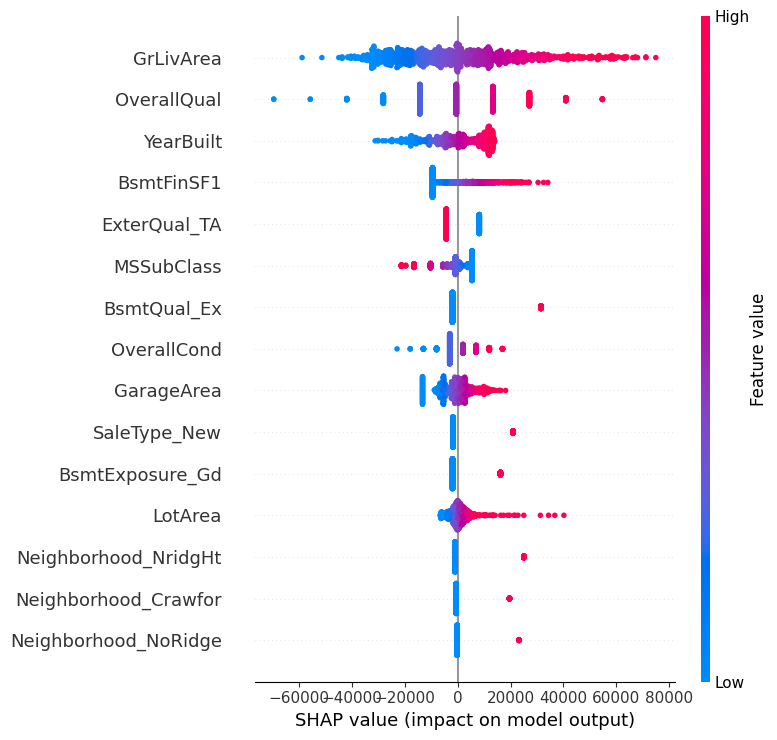

In [48]:
#https://medium.com/defactoblog/explainability-of-the-features-no-of-the-hyperparameters-ad797918155f
#shap.initjs()

# Initialize SHAP explainer
explainer = shap.Explainer(best_model, X_train[col_sel_best])

# Calculate SHAP values
shap_values = explainer(X_train[col_sel_best])

shap.summary_plot(shap_values, X_train[col_sel_best])

In [49]:
# Loop through each feature to plot one by one
#for feature in col_sel_best:
    #shap.dependence_plot(
        #ind=feature,                     # Pass the feature name
        #shap_values=shap_values_array,   # Use the extracted SHAP values
        #features=X_train_values,         # The dataset used to compute SHAP values
        #feature_names=col_sel_best       # Feature names to match SHAP values
    #)

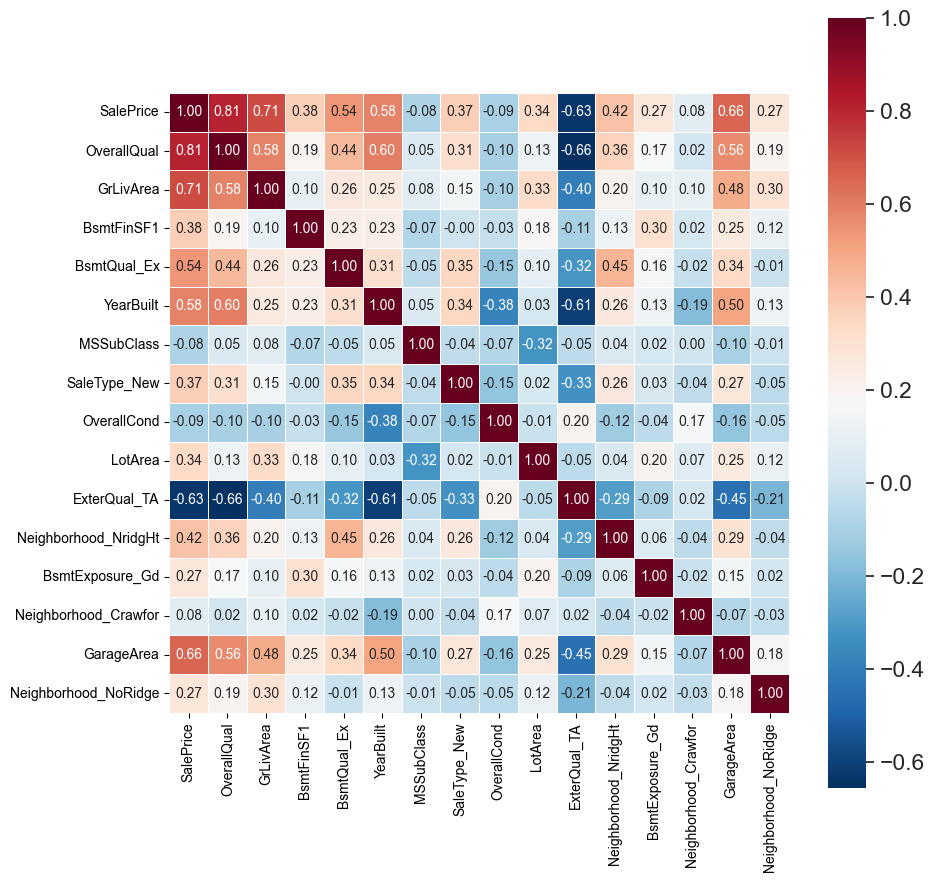

In [50]:
fig, ax = plt.subplots(figsize=(10,10)) #figsize in inches
X_for_correl= pd.concat([y, X[col_sel_best]], axis = 1)
cm = np.corrcoef(X_for_correl.values.T)
sns.set(style='whitegrid', context='notebook')
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cmap="RdBu_r",
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 linewidths = 0.6,
                 annot_kws={'size': 10},
                 yticklabels=X_for_correl.columns.tolist(),
                 xticklabels=X_for_correl.columns.tolist(),)

# Adjust the font size of the x-axis and y-axis categories
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

sns.set(font_scale=1)
# Next line is here in order to fix the bug
#ax.set_ylim(len(X_for_correl), 0) # https://github.com/matplotlib/matplotlib/issues/14751

plt.show()

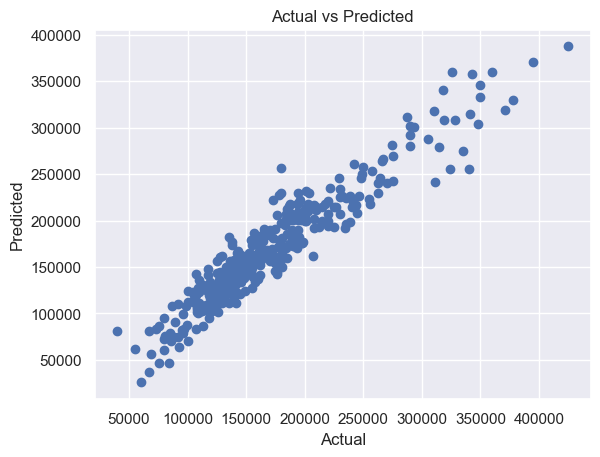

In [51]:
# 5. Visualize
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

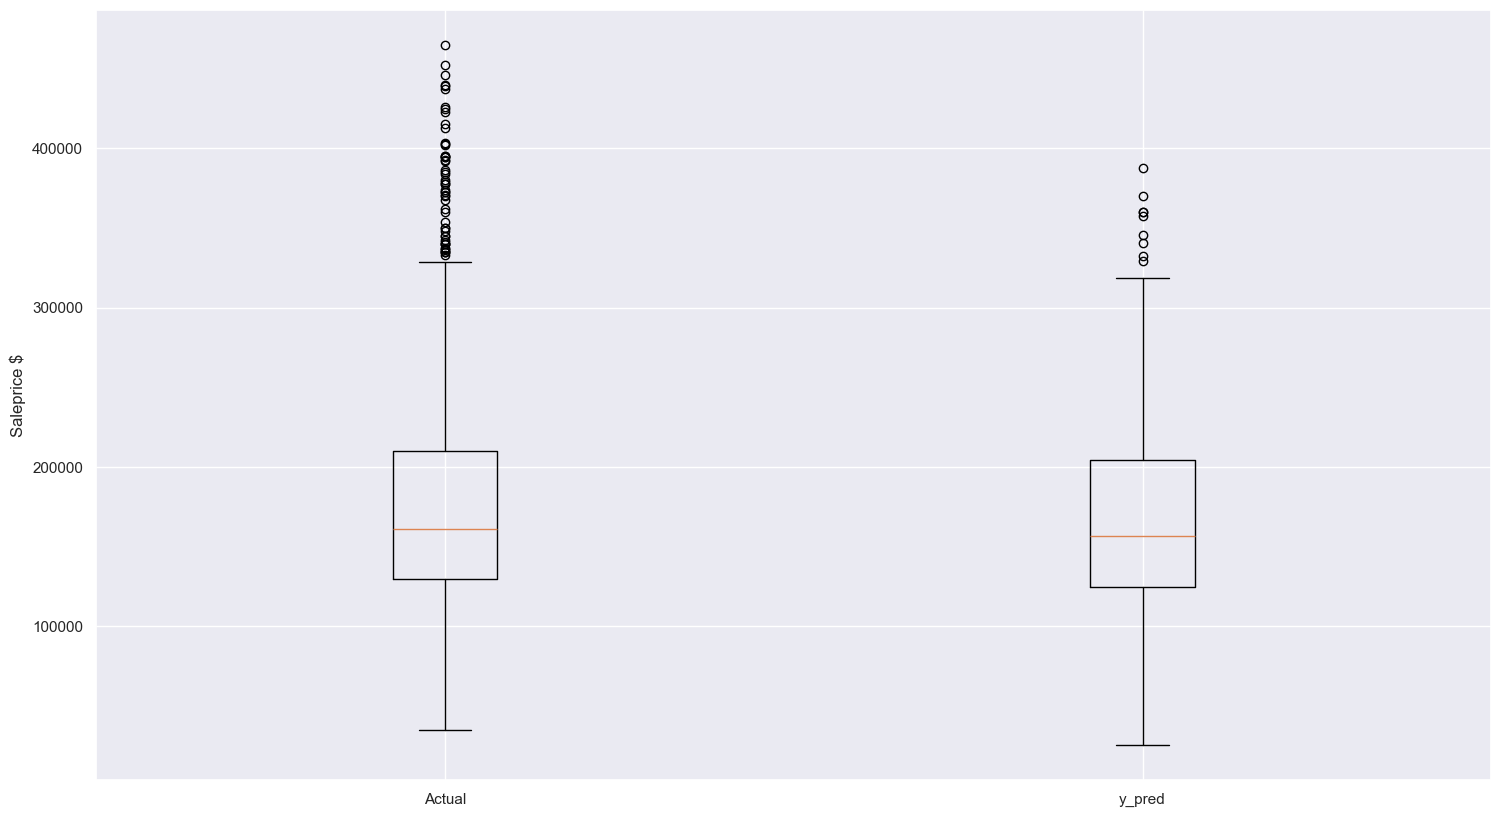

In [704]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.boxplot([y['SalePrice'].to_numpy(), np.array(y_pred).flatten()])
ax.set_xticklabels(['Actual', 'y_pred'])
ax.set_ylabel('Saleprice $')
plt.show()

In [705]:
print("Maximum difference in prediction:", np.max(y_test - y_pred))

Maximum difference in prediction: 84181.68503504014
Test: 424870
Maximum : 387403.7862125202


In [706]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("Y_train: ", y_train.shape)
print("Y_test: ", y_test.shape)

X_train:  (1052, 15)
X_test:  (351, 15)
Y_train:  (1052, 1)
Y_test:  (351, 1)


### Lazy classification for further best model selection nad hyperparameter tunning

In [707]:
#%pip install lazypredict

In [708]:
#https://medium.com/omics-diary/how-to-use-the-lazy-predict-library-to-select-the-best-machine-learning-model-65378bf4568e
from lazypredict.Supervised import LazyRegressor
import sys
import contextlib

reg = LazyRegressor(verbose=0, 
                    ignore_warnings=False, 
                    custom_metric=None,
                    predictions=False,
                    random_state = 42)

# Initialize LazyClassifier with the custom metric
# Redirect standard output temporarily to suppress prints
with open('nul', 'w') as f, contextlib.redirect_stdout(f):
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    model_dictionary = reg.provide_models(X_train, X_test, y_train, y_test)

# Print results
print(models)


100%|██████████| 42/42 [00:01<00:00, 24.06it/s]


                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
PoissonRegressor                             0.91       0.92  18703.33   
HuberRegressor                               0.90       0.90  20217.32   
LassoLarsCV                                  0.90       0.90  20261.36   
Lars                                         0.90       0.90  20261.36   
LassoLarsIC                                  0.90       0.90  20261.36   
LinearRegression                             0.90       0.90  20261.36   
TransformedTargetRegressor                   0.90       0.90  20261.36   
LarsCV                                       0.90       0.90  20261.36   
Ridge                                        0.90       0.90  20261.40   
Lasso                                        0.90       0.90  20261.77   
LassoLars                                    0.90       0.90  20261.77   
BayesianRidge                         

### GradientBoostingRegressor fine parameter tunning

In [711]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[col_sel_best], y, test_size=0.25, random_state=42)

# Define the parameter grid to search through
param_grid = {
    'n_estimators': [338, 339, 340],      # Number of boosting rounds
    'max_depth': [1, 2, 3],               # Maximum tree depth for base learners
    'learning_rate': [0.03, 0.04, 0.06],  # Boosting learning rate
    'subsample': [0.78, 0.79, 0.80],      # Subsample ratio of the training instance
}

# Initialize an empty list to store the results
results = []

# Loop through all parameter combinations
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            for subsample in param_grid['subsample']:
                
                # Initialize the GradientBoostingRegressor with the current set of parameters
                model_GradientBoostingRegressor = GradientBoostingRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    subsample=subsample,
                    random_state=42
                )
                
                # Fit the model on the training data
                model_GradientBoostingRegressor.fit(X_train, y_train)
                
                # Predict on the test set
                y_pred = model_GradientBoostingRegressor.predict(X_test)
                
                # Calculate the Mean Squared Error
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                
                # Append the results to the list
                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'subsample': subsample,
                    'rmse': rmse
                })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Display the best parameters based on the lowest RMSE
best_result = results_df.loc[results_df['rmse'].idxmin()]
print("Best Parameters:")
print(best_result)

# Re-train the model with the best parameters
best_params = best_result.to_dict()
model_GradientBoostingRegressor = GradientBoostingRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    random_state=42
)

# Fit the model on the training data
model_GradientBoostingRegressor.fit(X_train, y_train)

# Predict on the test set
y_pred = model_GradientBoostingRegressor.predict(X_test)

# Evaluate the final model
final_mse = mean_squared_error(y_test, y_pred)
print(f"Final Model RMSE: {np.sqrt(final_mse)}")


Best Parameters:
n_estimators      339.00
max_depth           2.00
learning_rate       0.04
subsample           0.79
rmse            19846.86
Name: 49, dtype: float64
Final Model RMSE: 19846.861905550995


In [735]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[col_sel_best], y, test_size=0.25, random_state=42)

# Define the parameter grid to search through
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5],  # Regularization parameter
    'max_iter': [200, 250],  # Maximum number of iterations
    'solver':['lbfgs', 'newton-cholesky']
}

# Initialize an empty list to store the results
results = []

# Loop through all parameter combinations
for alpha in param_grid['alpha']:
    for max_iter in param_grid['max_iter']:
        for solver in param_grid['solver']:
        
            # Initialize the Poisson Regressor with the current set of parameters
            model_PoissonRegressor = PoissonRegressor(alpha=alpha, max_iter=max_iter, solver=solver)
            
            # Fit the model on the training data
            model_PoissonRegressor.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = model_PoissonRegressor.predict(X_test)
            
            # Calculate the Mean Squared Error
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            
            # Append the results to the list
            results.append({
                'alpha': alpha,
                'max_iter': max_iter,
                'rmse': rmse,
                'solver': solver
        })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Display the best parameters based on the lowest RMSE
best_result = results_df.loc[results_df['rmse'].idxmin()]
pd.options.display.float_format = '{:.5f}'.format
print("Best Parameters:")
print(best_result)
pd.options.display.float_format = '{:.2f}'.format
# Re-train the model with the best parameters
best_params = best_result.to_dict()
model_PoissonRegressor = PoissonRegressor(alpha=best_params['alpha'], max_iter=int(best_params['max_iter']))
model_PoissonRegressor.fit(X_train, y_train)

# Predict on the test set
y_pred = model_PoissonRegressor.predict(X_test)



Best Parameters:
alpha               0.00010
max_iter                200
rmse            18703.33135
solver      newton-cholesky
Name: 1, dtype: object


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X[col_sel_best], y, test_size=0.25, random_state=42)

model_PoissonRegressor = PoissonRegressor(alpha=0.0001, fit_intercept=True, solver='newton-cholesky', max_iter=200, tol=0.0001, warm_start=False, verbose=0)

# Fit the model on the training data
model_PoissonRegressor.fit(X_train, y_train)
        
# Predict on the test set
y_pred = model_PoissonRegressor.predict(X_test)
        
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

18703.33135070038


C:\Users\Pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


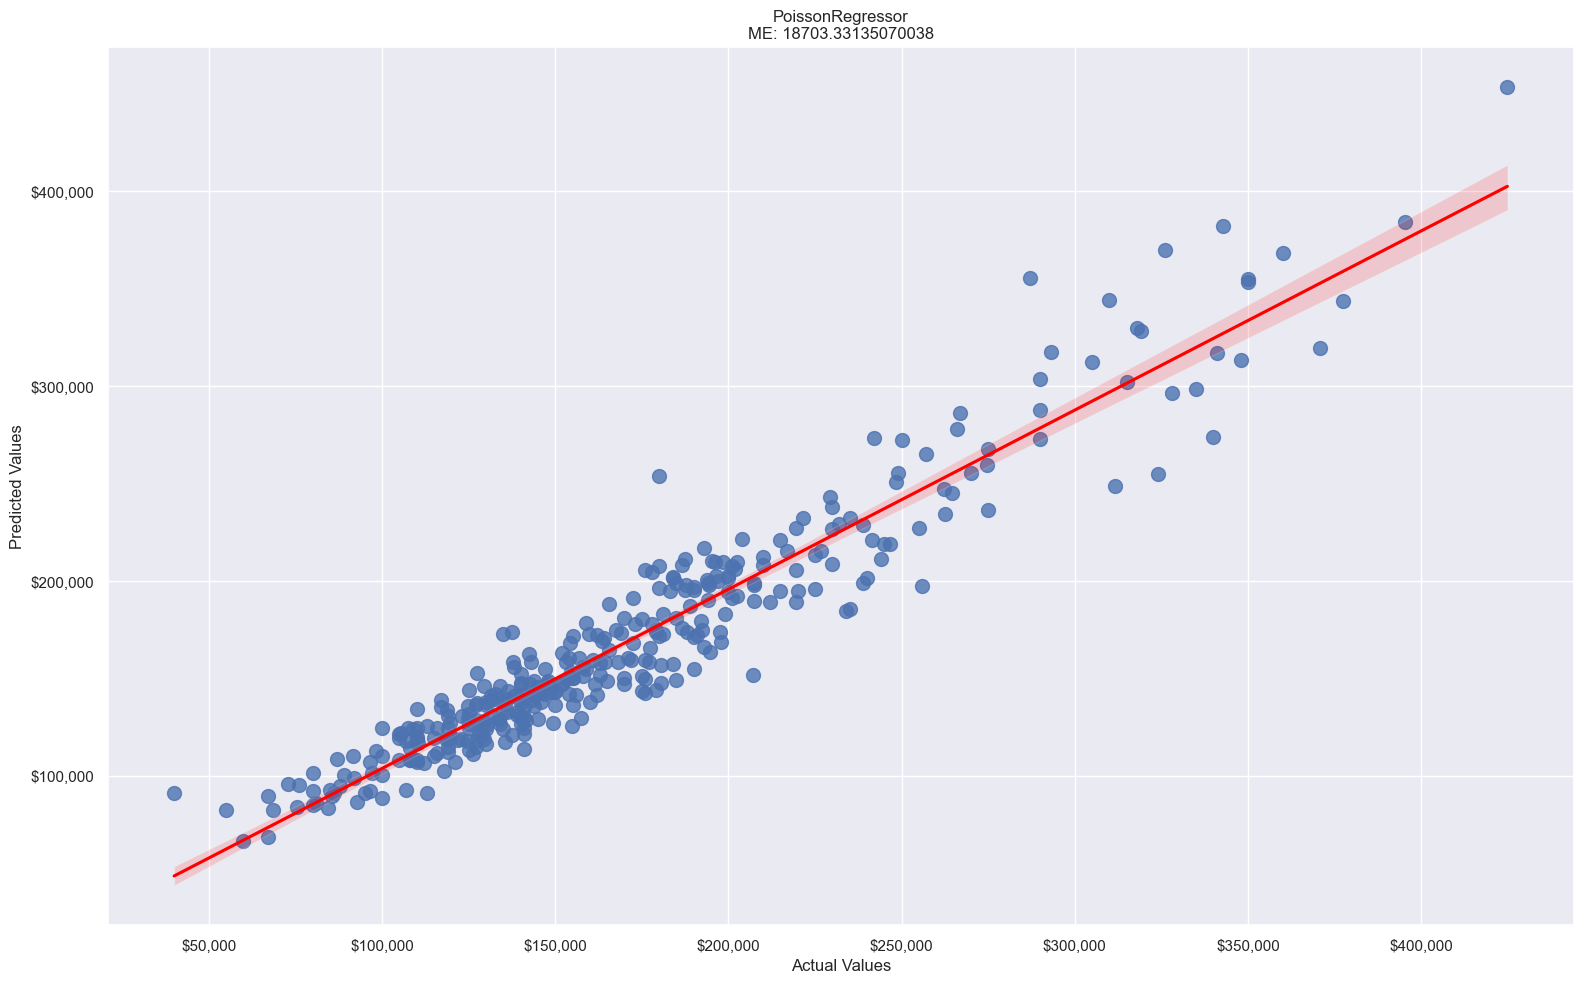

In [59]:
from matplotlib.ticker import FuncFormatter
# 5. Visualize
def currency_format(x, _):
    return f'${x:,.0f}'
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
ax = axes
sns.regplot(x=y_test, y=y_pred, ax=ax, scatter_kws={'s':100}, line_kws={'color':'red'})
ax.set_title(f'PoissonRegressor\nME: {rmse}')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.xaxis.set_major_formatter(FuncFormatter(currency_format))
ax.yaxis.set_major_formatter(FuncFormatter(currency_format))
plt.tight_layout()
plt.show()

### Keras Linear regression

In [810]:
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
import tensorflow as tf
import random
print('Version TensorFlow :',tf.__version__)

# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Force TensorFlow to use single-threaded operations and deterministic ops
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Enable deterministic operations
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow log messages
os.environ['CUDA_VISIBLE_DEVICES'] = ''   # Use CPU for consistent results

# Split the data into training and test sets, for neural network performance only normalized dataset is suitable
X_train, X_test, y_train, y_test = train_test_split(X_norm[col_sel_best], y, test_size=0.25, random_state=42)

# Define the root mean squared error function
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Cast y_pred to float32
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Define the hyperparameters to test
epochs_list = [1000]  # Different values for epochs
learning_rates = [0.15, 0.1]  # Different learning rates
#https://keras.io/api/optimizers/
optimizers = [
    tf.keras.optimizers.Adam, 
    tf.keras.optimizers.SGD, 
    tf.keras.optimizers.RMSprop, 
    tf.keras.optimizers.Adagrad, 
    tf.keras.optimizers.Adadelta, 
    tf.keras.optimizers.Adamax, 
    tf.keras.optimizers.Nadam, 
    tf.keras.optimizers.Ftrl, 
    tf.keras.optimizers.Lion  # Different optimizers
]

# Store results
results = []

# Loop through different combinations of hyperparameters
for epochs in epochs_list:
    for learning_rate in learning_rates:
        for optimizer in optimizers:
            # Define the model        
            model_nn = tf.keras.Sequential([
                # Input layer with 15 features
                Dense(256, input_dim = 15, activation='linear'),                  
                Dense(128, activation='linear'),                                  
                Dense(64, activation='linear'),                                  
                Dense(32, activation='linear'),                  
                #Dropout(0.1),                                  # Dropout layer to regularize the model                
                Dense(16, activation='linear'),                                 
                Dense(8, activation='linear'),                                
                Dense(1, activation='linear')                  # Output layer for regression
            ])
            
            # Compile the model with custom RMSE metric
            opt = optimizer(learning_rate=learning_rate)
            model_nn.compile(
                loss='mean_squared_error',
                optimizer=opt,
                metrics=[root_mean_squared_error]
            )

            # Train the model
            history = model_nn.fit(X_train, y_train, epochs=epochs, verbose=False)

            # Evaluate the model
            evaluation = model_nn.evaluate(X_test, y_test, verbose=0)
            mse, rmse = evaluation[0], evaluation[1]

            # Save the result
            results.append({
                'epochs': epochs,
                'learning_rate': learning_rate,
                'optimizer': optimizer.__name__,
                'mse': mse,
                'rmse': rmse
            })

# Convert results to a DataFrame for easier viewing 
results_df = pd.DataFrame(results)

# Find the best parameters based on RMSE
best_result = results_df.loc[results_df['rmse'].idxmin()]

print("Best Parameters:")
print(best_result)
print("\nAll Results:")
print(results_df)

Version TensorFlow : 2.18.0-dev20240819
Best Parameters:
epochs                  1000
learning_rate           0.15
optimizer               Ftrl
mse             404064768.00
rmse                19965.52
Name: 7, dtype: object

All Results:
    epochs  learning_rate optimizer                       mse           rmse
0     1000           0.15      Adam                       NaN            NaN
1     1000           0.15       SGD                       NaN            NaN
2     1000           0.15   RMSprop        736002238840832.00    26815176.00
3     1000           0.15   Adagrad              404332672.00       19971.49
4     1000           0.15  Adadelta              406847808.00       20033.80
5     1000           0.15    Adamax              458579520.00       21268.59
6     1000           0.15     Nadam                       NaN            NaN
7     1000           0.15      Ftrl              404064768.00       19965.52
8     1000           0.15      Lion 1397322145497547276288.00 362959

In [785]:
from tensorflow.keras.layers import LeakyReLU

In [829]:
# Define the hyperparameters for Adagrad fine tunning
epochs_list = [1000]  # Different values for epochs
learning_rates = [0.0005]  # Different learning rates
# Optimizer settings for Adadelta
epsilon = 1e-07
initial_accumulator_value=0.1
weight_decay = 1e-5
clipnorm = None
clipvalue = None
global_clipnorm = None
use_ema = True
ema_momentum = 0.99
ema_overwrite_frequency = None
loss_scale_factor = None
gradient_accumulation_steps = None
#https://keras.io/api/optimizers/
optimizers = [tf.keras.optimizers.Adagrad]

# Store results
results = []

# Loop through different combinations of hyperparameters
for epochs in epochs_list:
    for learning_rate in learning_rates:
        for optimizer in optimizers:
            # Define the model        
            model_nn = tf.keras.Sequential([
                # Input layer with 15 features
                Dense(256, input_dim = 15, activation='linear'),                 
                Dense(128, activation='linear'),                  
                Dense(64, activation='linear'),                  
                Dense(32, activation='linear'),                  
                #Dropout(0.1),                                  # Dropout layer to regularize the model              
                Dense(16, activation='linear'),              
                Dense(8, activation='linear'),               
                Dense(1, activation='linear')                  # Output layer for regression
            ])
            
            # Compile the model with custom RMSE metric
            opt = optimizer(
                learning_rate=learning_rate, 
                epsilon=epsilon, 
                weight_decay=weight_decay, 
                clipnorm=clipnorm, 
                clipvalue=clipvalue, 
                global_clipnorm=global_clipnorm, 
                use_ema=use_ema, 
                ema_momentum=ema_momentum, 
                ema_overwrite_frequency=ema_overwrite_frequency, 
                loss_scale_factor=loss_scale_factor, 
                gradient_accumulation_steps=gradient_accumulation_steps
            )
            
            model_nn.compile(
                loss='mean_squared_error',
                optimizer=opt,
                metrics=[root_mean_squared_error]
            )

            # Train the model
            history = model_nn.fit(X_train, y_train, epochs=epochs, verbose=False)

            # Evaluate the model
            evaluation = model_nn.evaluate(X_test, y_test, verbose=0)
            mse, rmse = evaluation[0], evaluation[1]

            # Save the result
            results.append({
                'epochs': epochs,
                'learning_rate': learning_rate,
                'optimizer': optimizer.__name__,
                'mse': mse,
                'rmse': rmse
            })

# Convert results to a DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Find the best parameters based on RMSE
best_result = results_df.loc[results_df['rmse'].idxmin()]


pd.options.display.float_format = '{:.5f}'.format
print("Best Parameters:")
print(best_result)
pd.options.display.float_format = '{:.2f}'.format

Best Parameters:
epochs                     1000
learning_rate           0.00050
optimizer               Adagrad
mse             417370592.00000
rmse                20302.73242
Name: 0, dtype: object


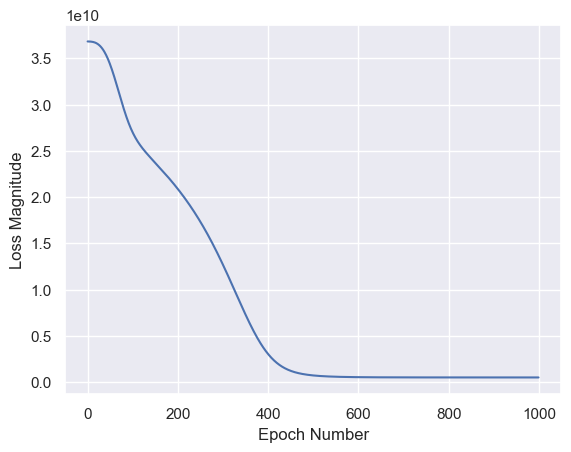

In [830]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.show()

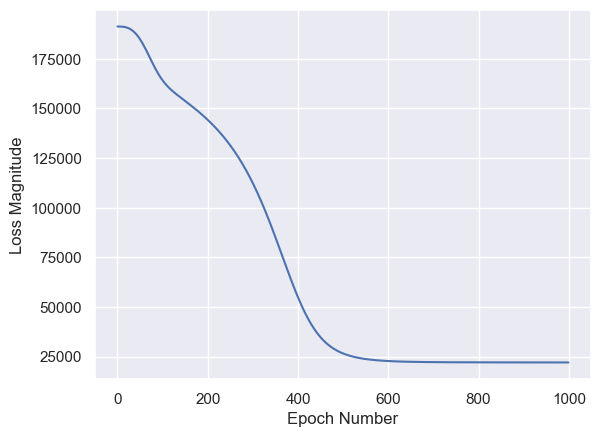

In [831]:
plt.plot(history.history['root_mean_squared_error'])
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.show()

### Prediction for specific House

In [832]:
# Define the feature names

features = ['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'BsmtQual_Ex', 
 'YearBuilt', 'MSSubClass', 'SaleType_New', 'OverallCond', 
 'LotArea', 'ExterQual_TA', 'Neighborhood_NridgHt', 'BsmtExposure_Gd', 
 'Neighborhood_Crawfor', 'GarageArea', 'Neighborhood_NoRidge']


# Define specific values for each feature
values = {
    'YearBuilt': 1998,
    'SaleType_New': 0,
    'MSSubClass': 120,
    'GrLivArea': 1338,
    'GarageArea': 470, 
    'LotArea': 9978,
    'BsmtFinSF1': 602,
    'ExterQual_TA': 1,
    'OverallQual': 8,
    'BsmtQual_Ex': 0,
    'BsmtExposure_Gd': 0,
    'OverallCond': 6,
    'Neighborhood_NridgHt': 0,
    'Neighborhood_Crawfor': 0,
    'Neighborhood_NoRidge': 0
}
real_price = 195500
# Calculate and print accuracy
def calculate_accuracy(predicted, real):
    return 100 - (abs(predicted - real) / real * 100)

# Create a DataFrame with a single row using the values
one_house = pd.DataFrame([values], columns=features)

model_PoissonRegressor.fit(X[col_sel_best], y)
predicted_price = model_PoissonRegressor.predict(one_house)
print(f"Predicted price for your beloved house by PR is: {int(round(predicted_price[0])):,}$ and accuracy is {calculate_accuracy(predicted_price, real_price)}")

model_GradientBoostingRegressor.fit(X[col_sel_best], y)
predicted_price = model_GradientBoostingRegressor.predict(one_house)
print(f"Predicted price for your beloved house by GBR is: {int(round(predicted_price[0])):,}$ and accuracy is {calculate_accuracy(predicted_price, real_price)}")

#Normalize input for nn prediction
scaler = preprocessing.StandardScaler()
scaler.fit(one_house)
one_house_scaled = scaler.transform(one_house)
#model_nn.fit(X[col_sel_best], y, epochs=1000, verbose=False)
predicted_price = model_nn.predict(one_house_scaled)
print(f"Predicted price for your beloved house by NN is: {int(round(predicted_price[0][0])):,}$ and accuracy is {calculate_accuracy(predicted_price, real_price)[0]}")

print(f"Real price was {int(round(real_price)):,}$")

Predicted price for your beloved house by PR is: 196,934$ and accuracy is [99.26663536]
Predicted price for your beloved house by GBR is: 217,097$ and accuracy is [88.95300083]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted price for your beloved house by NN is: 175,808$ and accuracy is [89.92754955]
Real price was 195,500$
